<a href="https://colab.research.google.com/github/AstroBoy1/santander/blob/master/xgboost_santander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, setup drive, read the data, reintall packages

In [1]:
!pip3 uninstall xgboost
!pip3 install xgboost
!pip uninstall sklearn
!pip install sklearn
!pip install scikit-optimize

Uninstalling xgboost-0.7.post4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.7.post4-py3.6.egg-info
    /usr/local/lib/python3.6/dist-packages/xgboost/*
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.7.post4
    100% |████████████████████████████████| 114.0MB 276kB/s 
Uninstalling sklearn-0.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/sklearn-0.0-py3.6.egg-info
Proceed (y/n)? y
  Successfully uninstalled sklearn-0.0
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
    100% |████████████████████████████████| 81kB 3.1MB/s 


In [2]:
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn import svm
from collections import Counter
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import time
import statistics
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from skopt import BayesSearchCV

Using TensorFlow backend.


In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_fn = '/content/gdrive/My Drive/santander_data/train.csv'
valid_fn = '/content/gdrive/My Drive/santander_data/test.csv'
pred_fn = '/content/gdrive/My Drive/santander_data/submission12.csv'
train_data_df = pd.read_csv(train_fn)
test_data_df = pd.read_csv(valid_fn)
train_data_x = train_data_df.drop(columns=["ID_code", "target"]).values
train_data_y = train_data_df["target"].values
test_data_x = test_data_df.drop(columns=["ID_code"]).values

#Data preprocessing

Check for missing values, which there are none

In [0]:
null_values = train_data_df.isnull().sum()
sum(null_values > 0)

0

Check the datatypes of the features, there are 200, all are float64

In [0]:
types = train_data_df.dtypes
sum(types == 'float64')

200

Scale the data between 0 and 1

In [0]:
scalerScaled = MinMaxScaler(feature_range=(0, 1))
scaled_x = scalerScaled.fit_transform(train_data_x)
scaled_x

array([[0.42785307, 0.32482435, 0.56805853, ..., 0.43095798, 0.32765751,
        0.56064496],
       [0.55721218, 0.42863943, 0.6812351 , ..., 0.4682771 , 0.6095461 ,
        0.60582746],
       [0.41196889, 0.48377668, 0.57806091, ..., 0.38194973, 0.42583343,
        0.58273586],
       ...,
       [0.5432771 , 0.39305749, 0.4870996 , ..., 0.45612437, 0.38087342,
        0.63919915],
       [0.46750324, 0.25309006, 0.66682332, ..., 0.67445942, 0.46661746,
        0.37047369],
       [0.5258457 , 0.36714503, 0.580254  , ..., 0.36840624, 0.29469964,
        0.57890533]])

Standardize the data to a standard normal gaussian distribution, assuming originally normal data

In [0]:
scalerStandard = StandardScaler().fit(train_data_x) 
standard_x = scalerStandard.transform(train_data_x) 
standard_x

array([[-0.57710174, -1.27373702,  0.45170728, ..., -0.37396811,
        -1.02639785,  0.21413482],
       [ 0.26995857, -0.62213756,  1.19036045, ..., -0.12939961,
         0.82541712,  0.50568523],
       [-0.68111341, -0.2760664 ,  0.51698836, ..., -0.69514059,
        -0.38144932,  0.35668144],
       ...,
       [ 0.17870987, -0.84546901, -0.07667568, ..., -0.20904171,
        -0.67680579,  0.72102365],
       [-0.31746727, -1.72398014,  1.09630117, ...,  1.22180338,
        -0.11352617, -1.01298853],
       [ 0.06456676, -1.00810962,  0.53130173, ..., -0.78389704,
        -1.24290845,  0.33196403]])

# Plotting

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


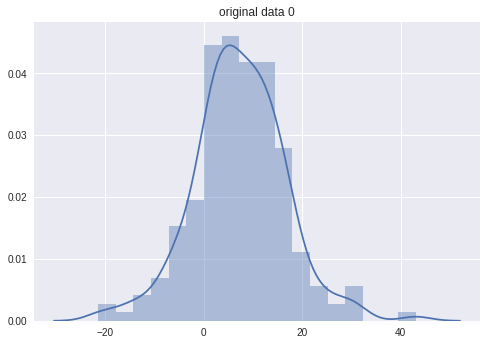

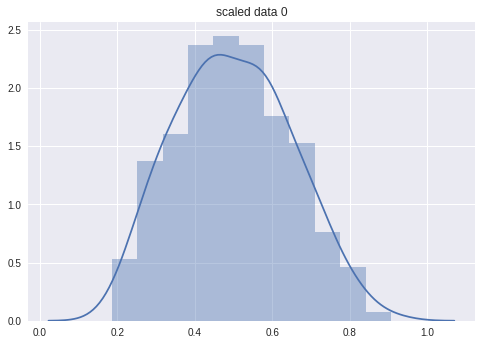

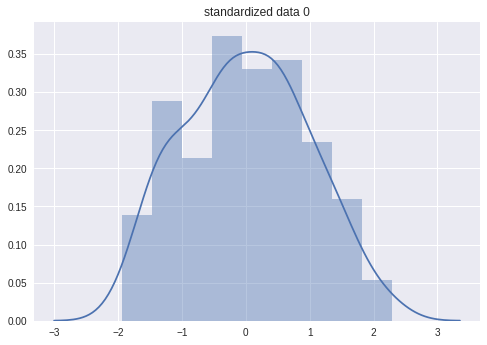

In [0]:
for i in range(0, 1):
  sns.distplot(train_data_x[i])
  plt.title("original data " + str(i))
  plt.figure()
  sns.distplot(scaled_x[i])
  plt.title("scaled data " + str(i))
  plt.figure()
  sns.distplot(standard_x[i])
  plt.title("standardized data " + str(i))

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


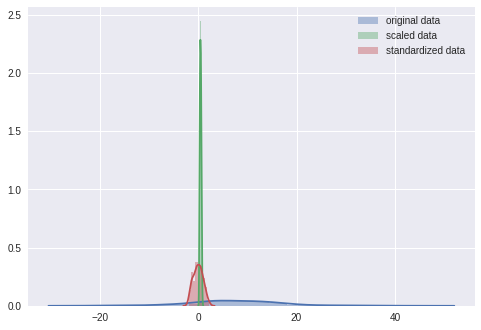

In [0]:
for i in range(0, 1):
  sns.distplot(train_data_x[i], label="original data")
  sns.distplot(scaled_x[i], label="scaled data")
  sns.distplot(standard_x[i], label="standardized data")
  plt.legend()

In [7]:
columns = train_data_df.columns.values
col = columns[1]
train_data_df[:100]

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


(array([  23.,  137.,  700., 1600., 2119., 2076., 1815.,  960.,  430.,
         140.]),
 array([2.6733 , 3.19352, 3.71374, 4.23396, 4.75418, 5.2744 , 5.79462,
        6.31484, 6.83506, 7.35528, 7.8755 ]),
 <a list of 10 Patch objects>)

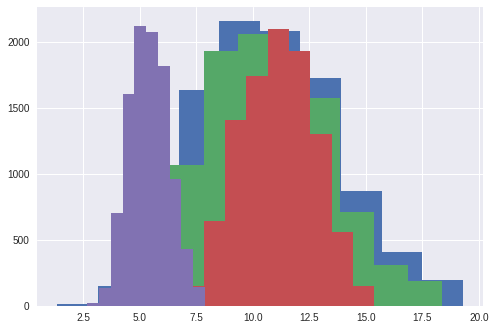

In [20]:
plt.hist(train_data_df['var_0'][:10000].values)
# plt.hist(train_data_df['var_1'][:10000].values)
plt.hist(train_data_df['var_2'][:10000].values)
# plt.hist(train_data_df['var_3'][:10000].values)
plt.hist(train_data_df['var_4'][:10000].values)
# plt.hist(train_data_df['var_5'][:10000].values)
plt.hist(train_data_df['var_6'][:10000].values)

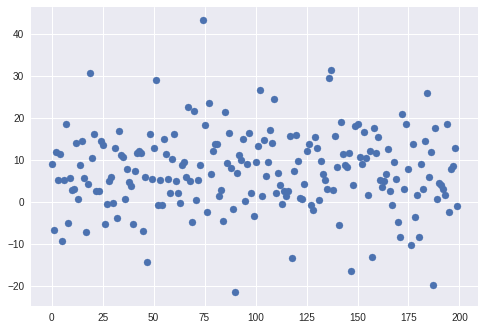

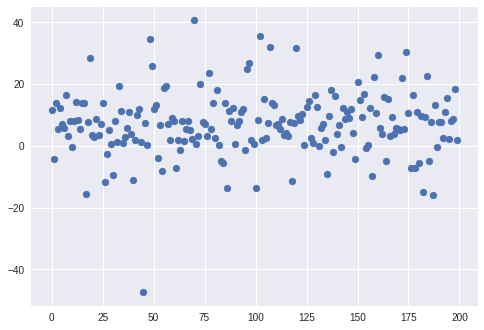

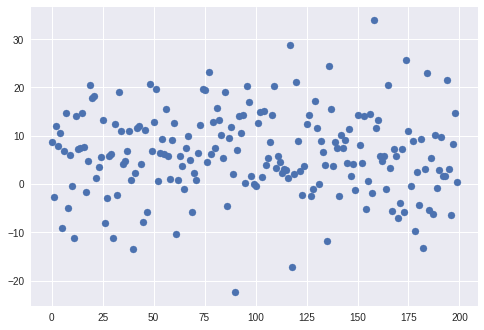

In [25]:
plt.scatter(list(range(200)), train_data_x[0])
plt.figure()
plt.scatter(list(range(200)), train_data_x[1])
plt.figure()
plt.scatter(list(range(200)), train_data_x[2])

# Fit the data with SVM

In [0]:
# clf = svm.SVC(gamma='scale')
# print("Fitting data")
# clf.fit(train_data_x[:length], train_data_y[:length])
# print("Predicting data")
# valid_pred = clf.predict(valid_data_x[:length])

SVM

In [0]:
output_df = pd.DataFrame()
output_df["ID_code"] = valid_data_df["ID_code"]
output_df["target"] = valid_pred
output_df.to_csv(pred_fn, index=False)

In [0]:
# Started around 10:30, finished 8pm

2019-02-23 05:48:31.692752


In [0]:
from joblib import dump, load
model_fn = '/content/gdrive/My Drive/santander_data/model.joblib'
dump(clf, model_fn)

['/content/gdrive/My Drive/santander_data/model.joblib']

In [0]:
clf2 = load(model_fn)

# XGBoost

Nested cross-validation

In [0]:
param['nthread'] = 4
param['eval_metric'] = 'auc'
param = {'max_depth':5, 'eta':0.3, 'silent':1, 'objective':'binary:logistic', 'subsample':0.8 }
num_rounds = 700
parameters = {'objective':'binary:logistic', 'max_depth':[3, 8], 'eta': 0.3, 'silent':1, 'subsample':0.8, 'eval_metric': 'auc', 'nthred': 4}
skf_outer = StratifiedKFold(n_splits=10, random_state=6)
skf_outer.get_n_splits(train_data_x, train_data_y)
for outer_train_index, outer_test_index in skf.split(train_data_x, train_data_y):
  skf = StratifiedKFold(n_splits=10, random_state=7)
  skf.get_n_splits(train_data_x[outer_train_index], train_data_y[outer_train_index])
  start = time.time()
  scores = []
  for train_index, test_index in skf.split(train_data_x[outer_train_index], train_data_y[outer_train_index]):
    X_train, X_test = train_data_x[train_index], train_data_x[test_index]
    y_train, y_test = train_data_y[train_index], train_data_y[test_index]
    param['scale_pos_weight'] = sum(y_train == 0) / sum(y_train == 1)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # early stopping uses the last one in evallist
    evallist  = [(dtrain,'train'), (dvalid,'eval')]
    # Go through all possible parameters
      bst = xgb.train(param, dtrain, num_rounds, early_stopping_rounds = 70, evals=evallist)
      print("Best score: ", bst.best_score)
      print("Best iteration: ", bst.best_iteration)
      print("Best ntree limit: ", bst.best_ntree_limit)
      scores.append(bst.best_score)
  end = time.time()
  print(end - start)

  print("Average score", statistics.mean(scores))
  print("Standard deviation: ", statistics.stdev(scores))

[0]	train-auc:0.646566	eval-auc:0.628803
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 70 rounds.
[1]	train-auc:0.686252	eval-auc:0.664215
[2]	train-auc:0.715803	eval-auc:0.685956
[3]	train-auc:0.736632	eval-auc:0.707514
[4]	train-auc:0.753894	eval-auc:0.718675
[5]	train-auc:0.768757	eval-auc:0.7322
[6]	train-auc:0.778968	eval-auc:0.741405
[7]	train-auc:0.791397	eval-auc:0.753428
[8]	train-auc:0.800995	eval-auc:0.76239
[9]	train-auc:0.808353	eval-auc:0.770906
[10]	train-auc:0.812649	eval-auc:0.772197
[11]	train-auc:0.819093	eval-auc:0.777129
[12]	train-auc:0.82575	eval-auc:0.782993
[13]	train-auc:0.831016	eval-auc:0.786439
[14]	train-auc:0.835669	eval-auc:0.788893
[15]	train-auc:0.840327	eval-auc:0.791865
[16]	train-auc:0.84336	eval-auc:0.793588
[17]	train-auc:0.846686	eval-auc:0.797412
[18]	train-auc:0.850931	eval-auc:0.799835
[19]	train-auc:0.855692	eval-auc:0.804384
[20]	train-auc:0.858808	eval-auc:0

KeyboardInterrupt: ignored

Inner cv

In [0]:
param_test1 = {
 'max_depth':range(5, 7, 1),
 'min_child_weight':range(1, 3, 1)
}
params = {'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'learning_rate':0.1, 
          'n_estimators':140, 'max_depth':5, 'min_child_weight':1, 'gamma':0, 'subsample':0.8, 
          'colsample_bytree':0.8, 'objective': 'binary:logistic', 'scale_pos_weight':1, 'seed':27, 'silent':False}
params = {'learning_rate':0.1, 
          'n_estimators':140, 'max_depth':5, 'min_child_weight':1, 'gamma':0, 'subsample':0.8, 
          'colsample_bytree':0.8, 'objective': 'binary:logistic', 'scale_pos_weight':1, 'seed':27, 'silent':False}
gsearch1 = GridSearchCV(estimator = XGBClassifier(params), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=50)

In [0]:
gsearch1.fit(train_data_x, train_data_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 22.3min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed: 22.3min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed: 22.3min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed: 22.4min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 44.9min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed: 44.9min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed: 44.9min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed: 45.0min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed: 46.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 46.9min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed: 46.9min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed: 46.9min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed: 46.9min
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed: 46.9min remaining: 

KeyboardInterrupt: ignored

Uninstalling sklearn-0.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/sklearn-0.0-py3.6.egg-info
Proceed (y/n)? y
  Successfully uninstalled sklearn-0.0
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [0]:
gsearch1.cv_results_

NameError: ignored

In [0]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 6, 'min_child_weight': 2}, 0.8528578236824618)

Train the best model on all of the data

In [0]:
# make prediction
#bst.save_model('/content/gdrive/My Drive/santander_data/xg_11.model')
start = time.time()
dtest = xgb.DMatrix(valid_data_x[:length])
preds = bst.predict(dtest)
output_df = pd.DataFrame()
output_df["ID_code"] = valid_data_df["ID_code"]
output_df["target"] = preds
output_df.to_csv(pred_fn, index=False)
end = time.time()
print(end - start)
len(preds)

5.239246129989624


200000

In [0]:
#bst = xgb.Booster({'nthread': 4})  # init model
#bst.load_model('model.bin')  # load data



```
# This is formatted as code
```

Tune XGBoost train until overfit, try dnn

# XGBoost Nested Cross Validation with Bayesian Hyperparameter Optimization

In [0]:
# SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
ITERATIONS = 50 # 1000

In [0]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        objective = 'binary:logistic',
        silent=0,
        tree_method='gpu_hist'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv("/content/gdrive/My Drive/santander_data/" + clf_name + "_cv_results.csv")

In [0]:
# Fit the model
result = bayes_cv_tuner.fit(train_data_x, train_data_y, callback=status_print)

Model #1
Best ROC-AUC: 0.8202
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.13031389926541354, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 21, 'min_child_weight': 2, 'n_estimators': 87, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216}

Model #2
Best ROC-AUC: 0.8489
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, 'learning_rate': 0.7988179462781242, 'max_delta_step': 17, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 68, 'reg_alpha': 0.0005266983003701547, 'reg_lambda': 276.5424475574225, 'scale_pos_weight': 0.3016410771843142, 'subsample': 0.9923710598637134}

Model #3
Best ROC-AUC: 0.8489
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, '

TODO: Nested

# Bayesian try 2

In [0]:
bayes_cv_tuner = BayesSearchCV(estimator = xgb.XGBClassifier(
                                n_jobs = -1,
                                objective = 'binary:logistic',
                                eval_metric = 'auc',
                                learning_rate = 0.1,
                                silent=1,
                                early_stopping = 200,
                                n_estimators = 8000,
                                tree_method='gpu_hist'),
    search_spaces = {
        'min_child_weight': (15, 20),
        'max_depth': (6, 8),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-2, 1000, 'log-uniform'),
        'reg_alpha': (1e-2, 1.0, 'log-uniform'),
        'gamma': (1e-2, 0.5, 'log-uniform'),
        'min_child_weight': (0, 20),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42),
    n_jobs = 3,
    n_iter = 10,   
    verbose = 500,
    refit = True,
    random_state = 786)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

In [0]:
result = bayes_cv_tuner.fit(train_data_x, train_data_y, callback=status_print)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
Memmapping (shape=(200000, 200), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_552_8759145358/552-140122418961936-c8a262b8cd464fab939a62acd85117a5.pkl
Memmapping (shape=(200000,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_552_8759145358/552-140122418961936-0c15515e6bed4e20afd87da65239f6b8.pkl
Memmapping (shape=(133332,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_552_8759145358/552-140122418961936-3cb2ce3f4842401290ebd2bced8354de.pkl
Pickling array (shape=(66668,), dtype=int64).
Memmapping (shape=(200000, 200), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_552_8759145358/552-140122418961936-c8a262b8cd464fab939a62acd85117a5.pkl
Memmapping (shape=(200000,), dtype=int64) to old file /dev/shm/joblib_memmapping_folder_552_8759145358/552-140122418961936-0c15515e6bed4e20afd87da65239f6b8.pkl
Memmappi

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed: 17.1min
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 17.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 17.1min finished
Model #3
Best ROC-AUC: 0.8869
Best params: {'colsample_bylevel': 0.18273244758535206, 'colsample_bytree': 0.7530295101748936, 'gamma': 0.2941753333970994, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 2, 'reg_alpha': 0.1186916389388348, 'reg_lambda': 0.03835472993899774, 'scale_pos_weight': 0.23326565231989196, 'subsample': 0.6601228271348841}

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
Memmapping (shape=(200000, 200), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_552_8759145358/552-140122418961936-c8a262b8cd464fab939a62acd85117a5.pkl
Memmapping (shape=(200000,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_552_8759145358/552-140122418961936-0c15515

# QDA

In [0]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(train_data_x[:length], train_data_y[:length])

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [0]:
preds = clf.predict(valid_data_x[:length])
print(preds[:10])

[1 0 0 0 0 0 0 0 0 0]


In [0]:
output_df = pd.DataFrame()
output_df["ID_code"] = valid_data_df["ID_code"]
output_df["target"] = preds
output_df.to_csv(pred_fn, index=False)